In [35]:
import h5py 
import photocurrent_sim
import numpy as np
import jax.random as jrand
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from circuitmap import NeuralDemixer

import sys
sys.path.append('../')
import nmu
import subtractr
import grid_utils as util
import subtract_utils
from subtract_utils import traces_tensor_to_map

In [36]:
# load dataset
dataset_path = '../data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/220308_B6_Chrome2fGC8_030822_Cell2_OpsPositive_A_planes_cmReformat.mat'
with h5py.File(dataset_path) as f:
    pscs = np.array(f['pscs']).T
    stim_mat = np.array(f['stimulus_matrix']).T
    targets = np.array(f['targets']).T
    powers = np.max(stim_mat, axis=0)

    valid_idxs = (powers > 0)
    pscs = pscs[valid_idxs]
    stim_mat = stim_mat[:,valid_idxs]
    powers = powers[valid_idxs]




# Grab traces with pure photocurrent
Idea is that at low powers, we should have some traces with only photocurrent and no PSCs. We'll try using these trials to extract the photocurrent shape.

First we form a tensor of traces so that it's easy to pick traces which come from the center of the grid (and hence will have photocurrents)

In [37]:
raw_tensor = util.make_psc_tensor_multispot(pscs, powers, targets, stim_mat)

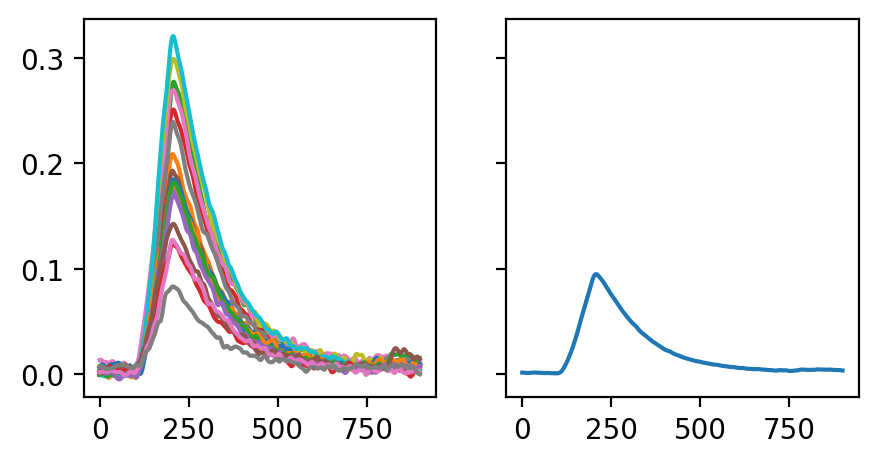

In [38]:
center_traces = raw_tensor[0, 12:15, 12:15, -3, :].reshape(-1, 900)
valid_rows = ~np.any(np.isnan(center_traces), axis=-1)
center_traces = center_traces[valid_rows,:]

# extract opsin waveform
U, S, V = np.linalg.svd(center_traces, full_matrices=True)
waveform = V[0,:]
if np.mean(waveform) < 0:
    waveform = -waveform

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(5,2.5), sharey=True, dpi=200)
axs[0].plot(center_traces.T)
axs[1].plot(waveform)
plt.show()

## Scale extracted waveform for each trace

In [39]:
waveform /= np.max(waveform)
U_init = np.linalg.lstsq(waveform[:, None], pscs.T, rcond=0.01)[0].T

# init_factors = [(U_init, waveform[None,:])]
# factors = nmu.recursive_nmu(
#     pscs,
#     init_factors=init_factors,
#     r=1,
#     update_v=False,
# )

In [40]:
# est = np.outer(factors[0][0], waveform)

est = np.outer(U_init, waveform)
subtracted = pscs - est

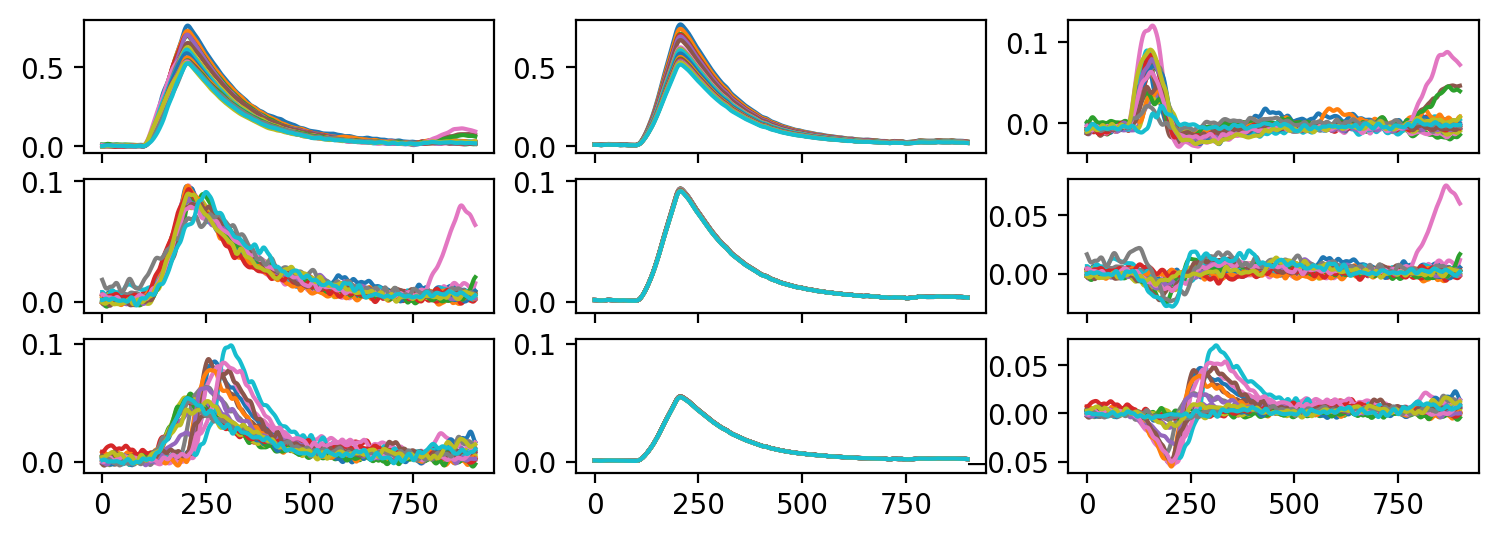

In [41]:

fig, axs = plt.subplots(nrows=3, ncols = 3, figsize=(9,3), dpi=200, sharex=True)
ys = np.sum(est, axis=-1)
idxs = np.argsort(ys)[::-1]

psc_starts = (1, 500, 1000)
plot_step = 1
num_to_plot= 20

for i in range(len(psc_starts)):

    axs[i,0].plot(pscs[idxs[psc_starts[i]:(psc_starts[i]+num_to_plot)]].T)
    axs[i,1].plot(est[idxs[psc_starts[i]:(psc_starts[i]+num_to_plot)]].T)
    axs[i,2].plot(subtracted[idxs[psc_starts[i]:(psc_starts[i]+num_to_plot)]].T)

    # make ylim of first two plots match
    axs[i,1].set_ylim(axs[i,0].get_ylim())

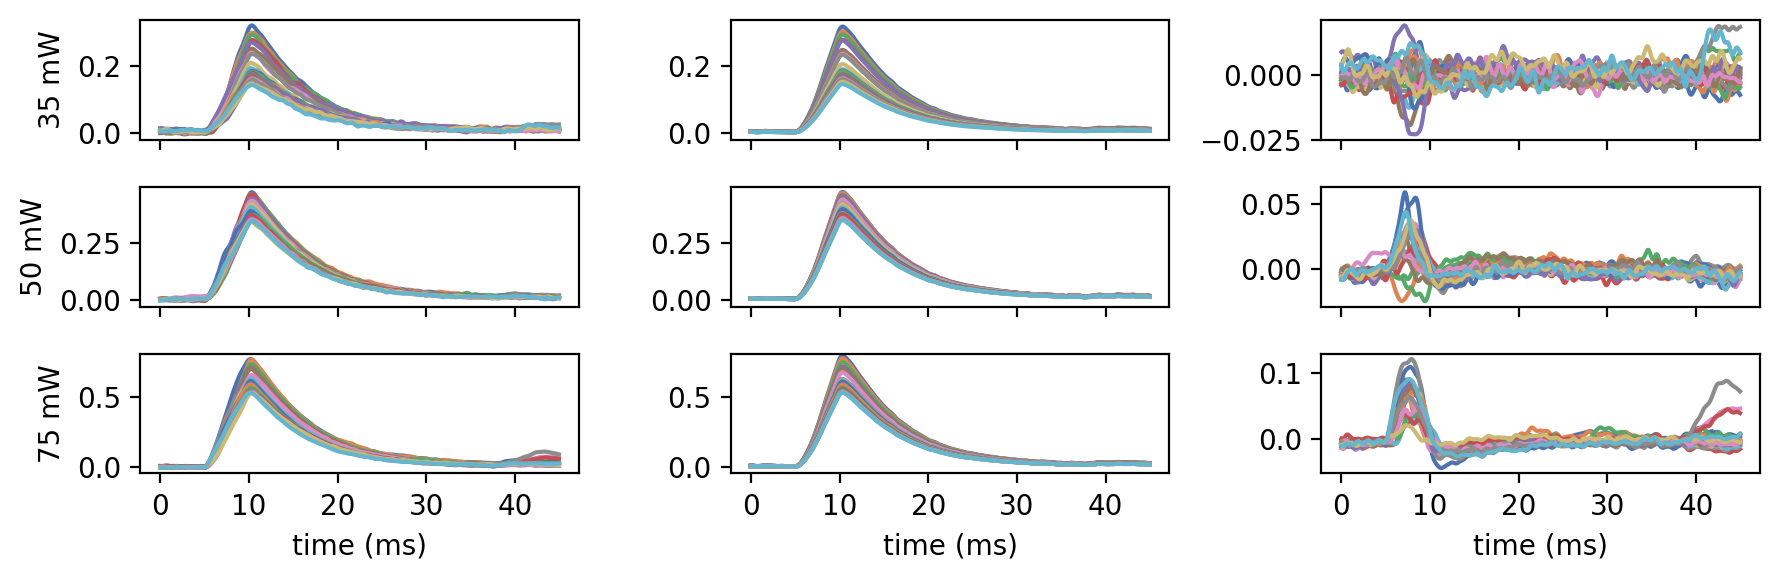

In [51]:
import seaborn as sns
sns.set_palette('deep')

fig, axs = plt.subplots(nrows=3, ncols = 3, figsize=(9,3), dpi=200, sharex=True)
unique_powers = np.unique(powers)
time = np.arange(0,900) * 0.05
for i in range(len(unique_powers)):
    these_trials = (powers == unique_powers[i])
    these_pscs = pscs[these_trials]
    these_ests = est[these_trials]
    these_subtracted = subtracted[these_trials]

    # order each by magnitude of photocurrent
    ordered_idx = np.argsort(np.sum(these_ests, axis=-1))[::-1]
    these_pscs = these_pscs[ordered_idx]
    these_ests = these_ests[ordered_idx]
    these_subtracted = these_subtracted[ordered_idx]

    axs[i,0].plot(time, these_pscs[0:20].T)
    axs[i,1].plot(time, these_ests[0:20].T)
    axs[i,2].plot(time, these_subtracted[0:20].T)

    # make ylim of first two plots match
    axs[i,1].set_ylim(axs[i,0].get_ylim())

    axs[i,0].set_ylabel('%d mW' % unique_powers[i])

for i in range(3):
    axs[-1, i].set_xlabel('time (ms)')
plt.tight_layout()
plt.show()

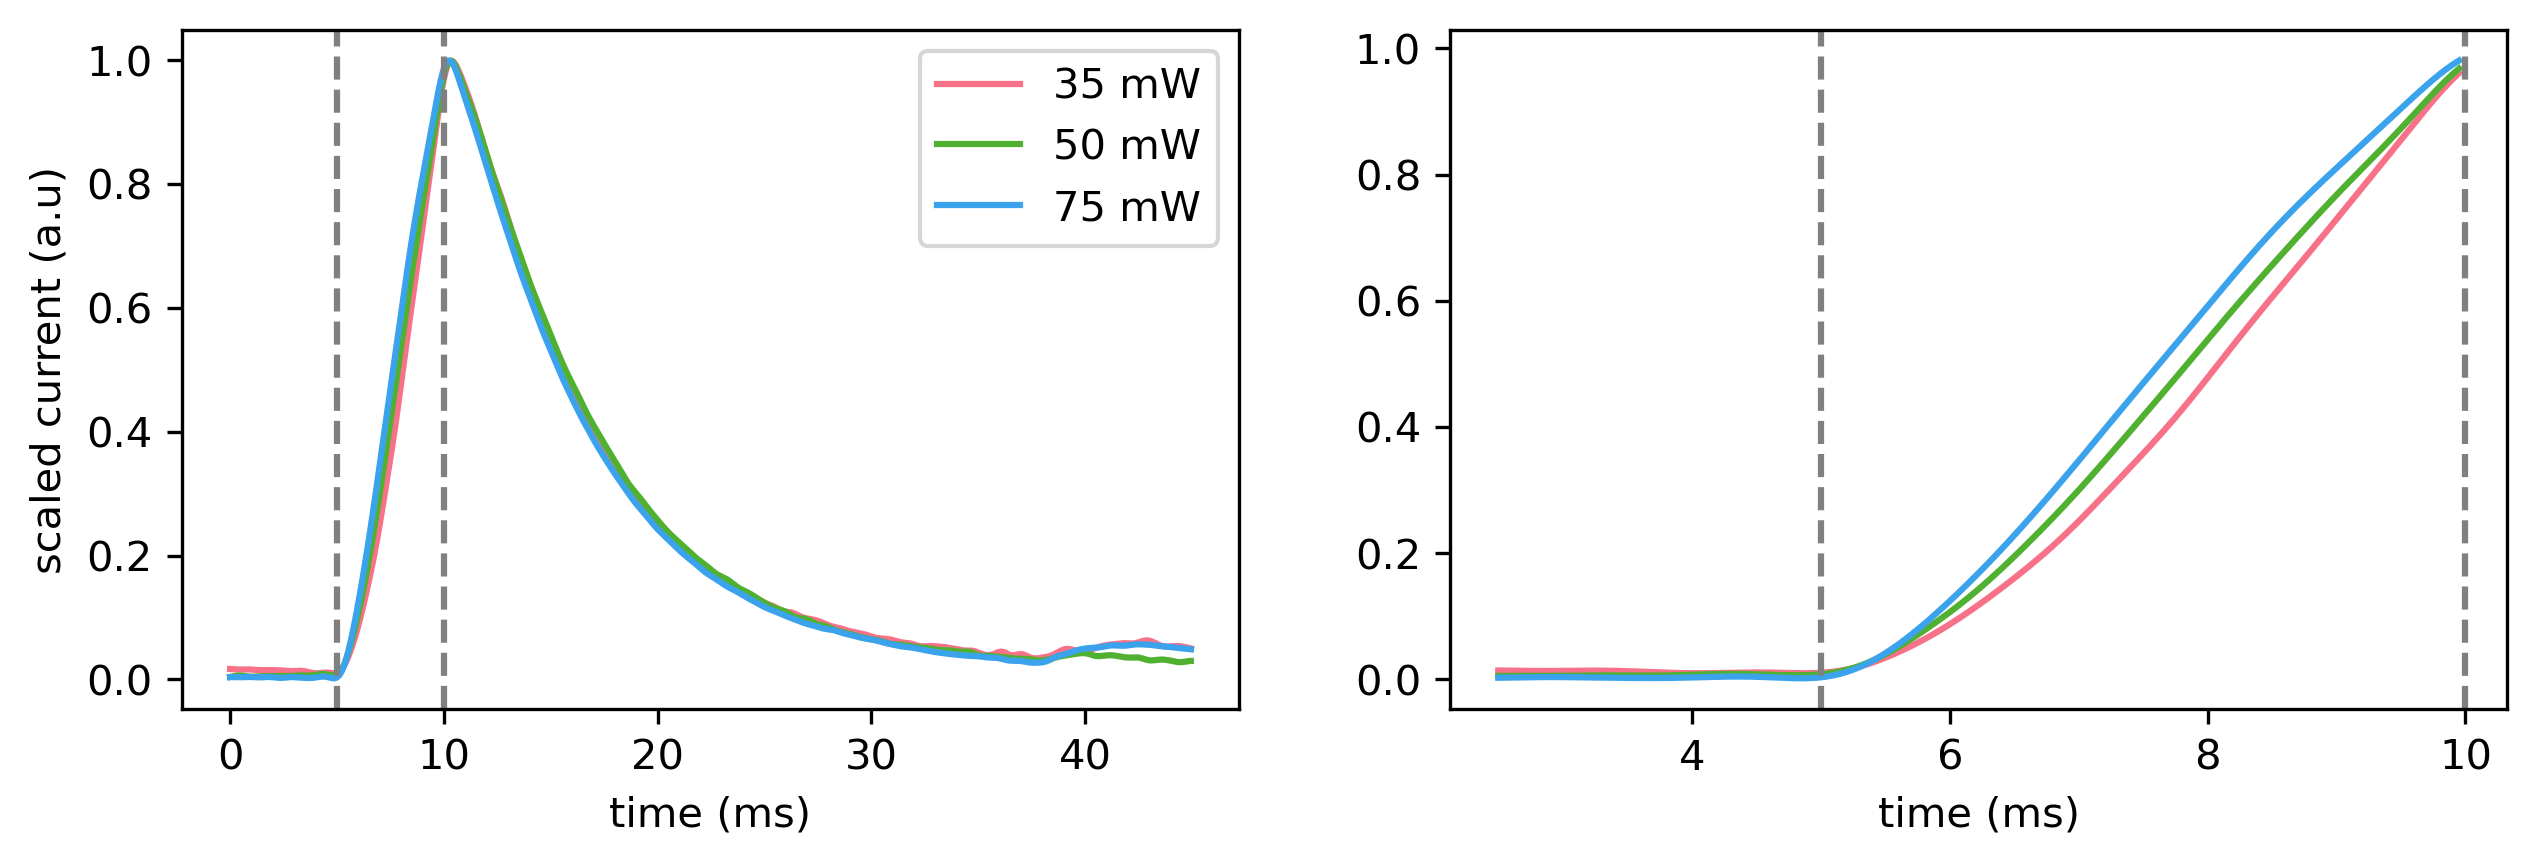

In [62]:

fig, axs = plt.subplots(1, 2, figsize=(10,3), dpi=300)
colors = sns.husl_palette(3)
for i in range(len(unique_powers)):
    these_trials = (powers == unique_powers[i])
    these_pscs = pscs[these_trials]

    # order each by magnitude of photocurrent
    ordered_idx = np.argsort(np.sum(these_pscs, axis=-1))[::-1]
    these_pscs = these_pscs[ordered_idx]

    # average
    power_template = these_pscs[0:20,:]
    # power_template -= np.mean(power_template[:, 0:50], axis=-1, keepdims=True)
    power_template /= np.max(power_template, axis=-1, keepdims=True)
    power_template = np.mean(power_template, axis=0)
    axs[1].plot(np.arange(50, 200) * 0.05, power_template[50:200], color=colors[i], label='%d mW' % unique_powers[i])
    axs[1].set_xlabel('time (ms)')

    axs[0].plot(np.arange(0, 900) * 0.05, power_template, color=colors[i], label='%d mW' % unique_powers[i])

axs[0].legend()
axs[0].set_ylabel('scaled current (a.u)')
axs[0].set_xlabel('time (ms)')

axs[0].axvline(x = 5, linestyle='--', color='grey')
axs[0].axvline(x = 10, linestyle='--', color='grey')
axs[1].axvline(x = 5, linestyle='--', color='grey')
axs[1].axvline(x = 10, linestyle='--', color='grey')

## Iterative Rank-1 approach
- We now know that the shape of the waveform changes subtly with large photocurrents. To deal with this, we'll try the following iterative approach: starting at low powers, fit using rank-1 underapprox. Then use the inferred waveform as initialization for the next highest power, and continue up at each power.

In [17]:
est = subtractr.estimate_photocurrents(pscs, powers, rank=3, 
    stepwise=True, separate_by_power=True, stepwise_constrain_V=True)

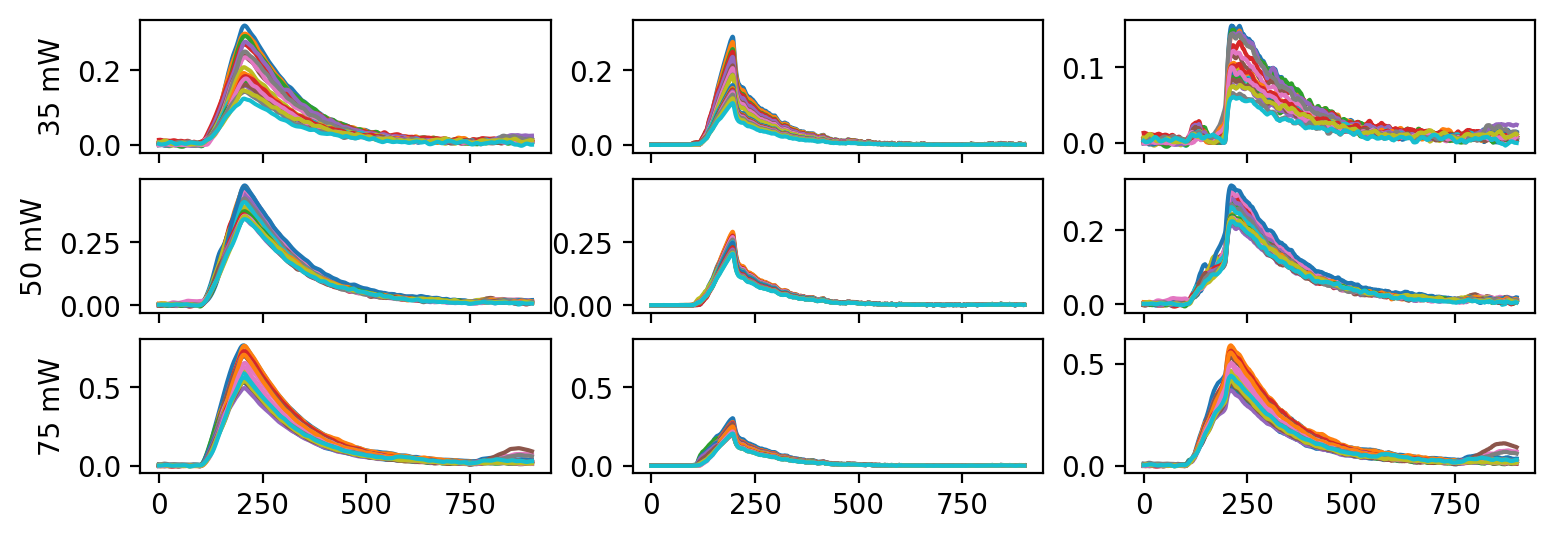

In [19]:
subtracted = pscs - est
fig, axs = plt.subplots(nrows=3, ncols = 3, figsize=(9,3), dpi=200, sharex=True)
unique_powers = np.unique(powers)
for i in range(len(unique_powers)):
    these_trials = (powers == unique_powers[i])
    these_pscs = pscs[these_trials]
    these_ests = est[these_trials]
    these_subtracted = subtracted[these_trials]

    # order each by magnitude of photocurrent
    ordered_idx = np.argsort(np.sum(these_ests, axis=-1))[::-1]
    these_pscs = these_pscs[ordered_idx]
    these_ests = these_ests[ordered_idx]
    these_subtracted = these_subtracted[ordered_idx]

    axs[i,0].plot(these_pscs[0:20].T)
    axs[i,1].plot(these_ests[0:20].T)
    axs[i,2].plot(these_subtracted[0:20].T)

    # make ylim of first two plots match
    axs[i,1].set_ylim(axs[i,0].get_ylim())

    axs[i,0].set_ylabel('%d mW' % unique_powers[i])
plt.show()